<a href="https://colab.research.google.com/github/alejitovm97-byte/Alejo-Varelas-projects/blob/main/HRP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

HRP + QUALITY BOOST PORTFOLIO — PIPELINE

[T0] Training: 2020-03-31 → 2023-03-30


[*********************100%***********************]  25 of 25 completed


  HRP optimised — 25 assets
  Quality Boost applied (alpha=0.3)
  First period — no buffer applied


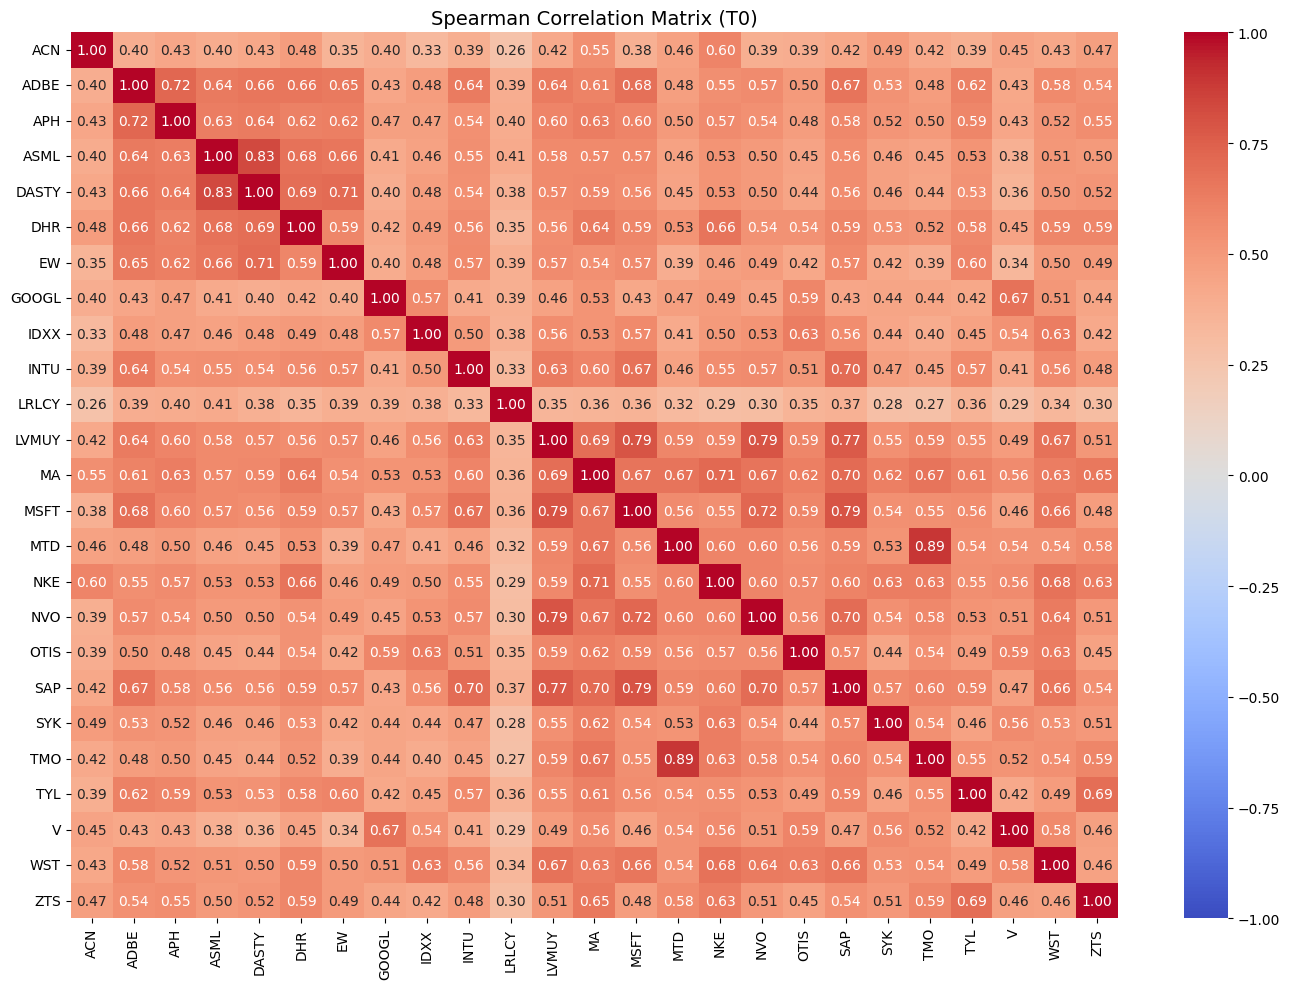

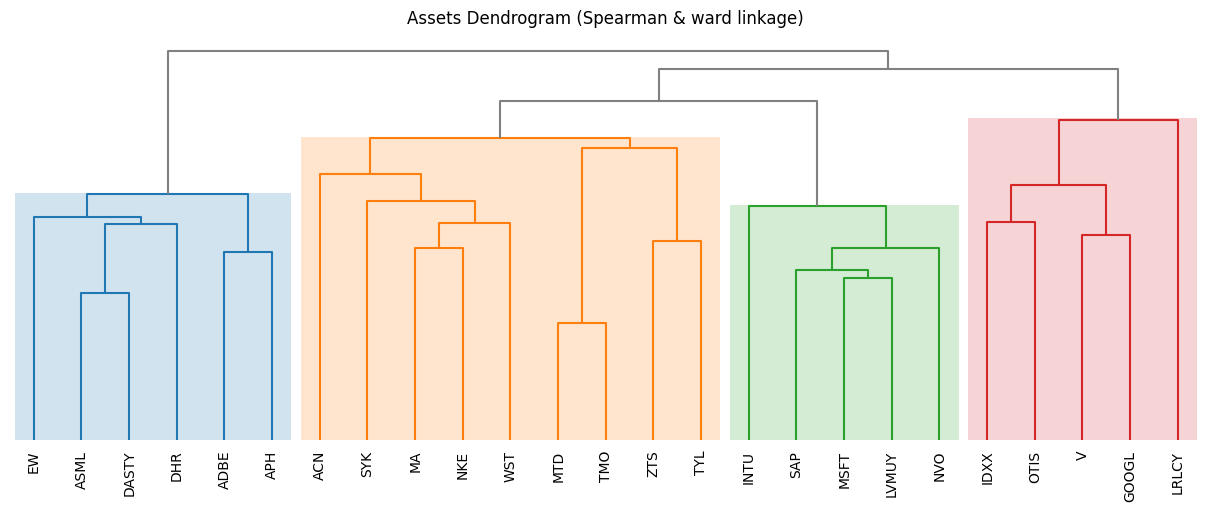


[T1] Training: 2021-09-30 → 2023-09-30


[*********************100%***********************]  25 of 25 completed
[                       0%                       ]

  HRP optimised — 25 assets
  Quality Boost applied (alpha=0.3)
  Buffer applied — 20 trades, turnover: 18.83%

[T2] Training: 2021-03-31 → 2024-03-30


[*********************100%***********************]  25 of 25 completed
[                       0%                       ]

  HRP optimised — 25 assets
  Quality Boost applied (alpha=0.3)
  Buffer applied — 26 trades, turnover: 37.60%

[T3] Training: 2021-09-30 → 2024-09-30


[*********************100%***********************]  25 of 25 completed


  HRP optimised — 25 assets
  Quality Boost applied (alpha=0.3)
  Buffer applied — 22 trades, turnover: 27.73%

[BACKTEST] Running backtest vs MSCI World (URTH)...


[*********************100%***********************]  33 of 33 completed


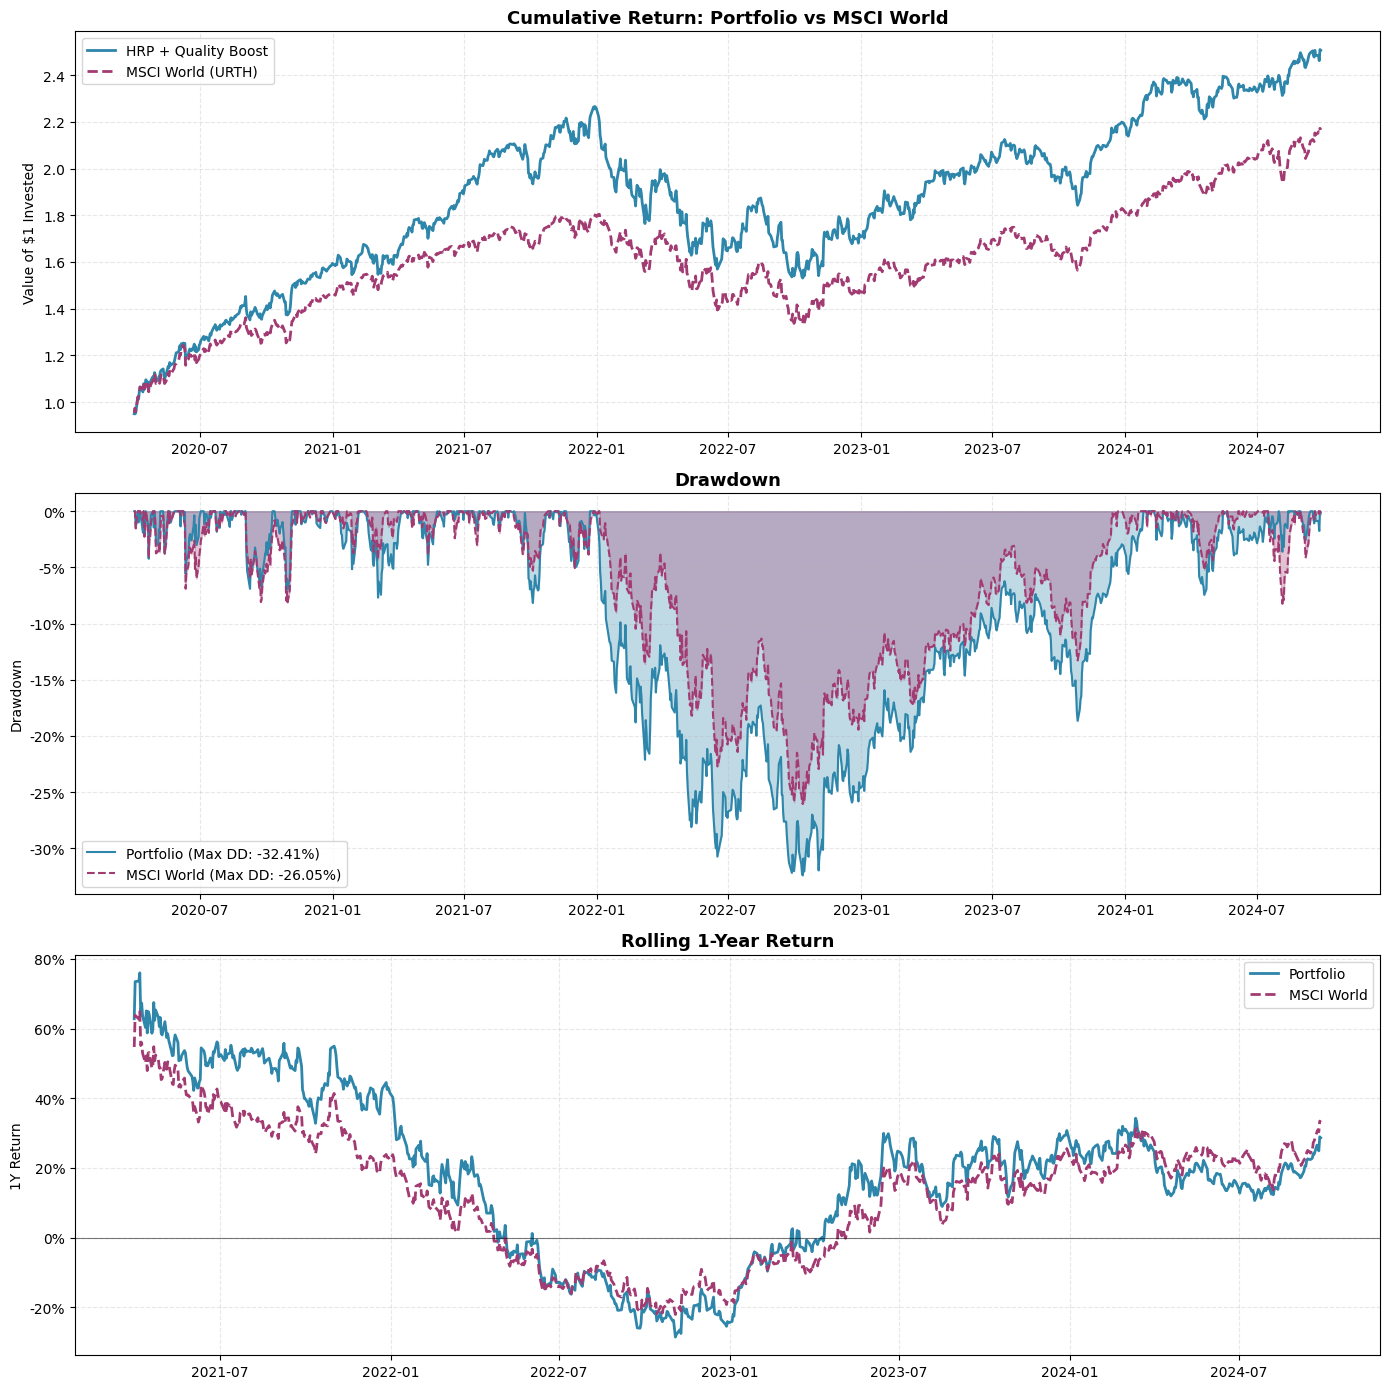


                         PERFORMANCE SUMMARY                          
  Period: 2020-04-01 → 2024-09-27
  Trading days: 1131

Metric                            HRP + Quality         MSCI World      Alpha
----------------------------------------------------------------------
  Cumulative Return                     150.65%            116.58%     34.07%
  Annualised Return                      22.72%             18.79%      3.93%
  Annualised Volatility                  19.95%             17.09%      2.85%
  Sharpe Ratio                            1.139              1.099     +0.040
  Sortino Ratio                           1.696              1.554     +0.142
  Max Drawdown                          -32.41%            -26.05%     -6.36%
  Calmar Ratio                            0.701              0.721     -0.020
  Win Rate                               53.76%             54.73%     -0.97%


In [3]:
"""
HRP + Quality Boost Portfolio Model
====================================
Hierarchical Risk Parity with a multiplicative quality tilt.

Pipeline:
  1. Download price data from Yahoo Finance
  2. Compute Spearman correlation matrix
  3. Run HRP optimisation (riskfolio-lib, Ward linkage)
  4. Apply Quality Boost: multiplicative tilt based on fundamental scores
  5. Smart rebalancing buffer: freeze positions with |Δw| < threshold
  6. Backtest vs MSCI World (URTH)

Author : Alejo Varela
Program: Master in Finance & Banking — Universitat Pompeu Fabra
"""

import warnings
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import riskfolio as rp

warnings.filterwarnings("ignore")

# ──────────────────────────────────────────────────────────────────────────────
# 1. CONFIGURATION
# ──────────────────────────────────────────────────────────────────────────────

# Each period defines a training window for HRP optimisation.
# The portfolio is rebalanced at the start of each new period.
PERIODS = {
    "T0": {
        "train_start": "2020-03-31",
        "train_end":   "2023-03-30",
        "hold_start":  "2020-03-31",
        "hold_end":    "2021-09-29",
        "assets": [
            "MA", "MSFT", "NKE", "WST", "IDXX", "DASTY", "TYL", "NVO", "ADBE", "SAP",
            "GOOGL", "V", "TMO", "LVMUY", "DHR", "SYK", "LRLCY", "ACN", "OTIS", "ZTS",
            "ASML", "INTU", "MTD", "EW", "APH"
        ],
        "quality_scores": {
            "MA": 1.60, "MSFT": 1.55, "NKE": 1.54, "WST": 1.45, "IDXX": 1.42,
            "DASTY": 1.42, "TYL": 1.40, "NVO": 1.40, "ADBE": 1.38, "SAP": 1.38,
            "GOOGL": 1.37, "V": 1.35, "TMO": 1.32, "LVMUY": 1.30, "DHR": 1.27,
            "SYK": 1.25, "LRLCY": 1.22, "ACN": 1.20, "OTIS": 1.17, "ZTS": 1.15,
            "ASML": 1.12, "INTU": 1.10, "MTD": 1.07, "EW": 1.04, "APH": 1.00
        },
    },
    "T1": {
        "train_start": "2021-09-30",
        "train_end":   "2023-09-30",
        "hold_start":  "2021-09-30",
        "hold_end":    "2022-03-30",
        "assets": [
            "MSFT", "MA", "DASTY", "WST", "SAP", "NKE", "IDXX", "TYL", "UNH",
            "ADBE", "NVO", "GOOGL", "LVMUY", "TMO", "DHR", "SYK", "ACN", "ZTS",
            "APH", "ASML", "OTIS", "MTD", "EW", "LRLCY", "INTU"
        ],
        "quality_scores": {
            "MSFT": 1.60, "MA": 1.56, "DASTY": 1.52, "WST": 1.48, "SAP": 1.45,
            "NKE": 1.44, "IDXX": 1.40, "TYL": 1.40, "UNH": 1.38, "ADBE": 1.38,
            "NVO": 1.36, "GOOGL": 1.33, "LVMUY": 1.31, "TMO": 1.28, "DHR": 1.26,
            "SYK": 1.23, "ACN": 1.21, "ZTS": 1.18, "APH": 1.16, "ASML": 1.13,
            "OTIS": 1.10, "MTD": 1.08, "EW": 1.05, "LRLCY": 1.03, "INTU": 1.00
        },
    },
    "T2": {
        "train_start": "2021-03-31",
        "train_end":   "2024-03-30",
        "hold_start":  "2022-03-31",
        "hold_end":    "2023-09-29",
        "assets": [
            "MSFT", "MA", "UNH", "DASTY", "SAP", "WST", "IDXX", "LZAGY", "SNPS",
            "ACN", "NVO", "GOOGL", "LVMUY", "NKE", "TMO", "V", "ADBE", "DHR",
            "TYL", "SYK", "ZTS", "APH", "EW", "MTD", "RMD"
        ],
        "quality_scores": {
            "MSFT": 1.60, "MA": 1.58, "UNH": 1.50, "DASTY": 1.49, "SAP": 1.48,
            "WST": 1.47, "IDXX": 1.42, "LZAGY": 1.42, "SNPS": 1.40, "ACN": 1.40,
            "NVO": 1.37, "GOOGL": 1.34, "LVMUY": 1.32, "NKE": 1.29, "TMO": 1.27,
            "V": 1.24, "ADBE": 1.21, "DHR": 1.19, "TYL": 1.16, "SYK": 1.14,
            "ZTS": 1.11, "APH": 1.08, "EW": 1.06, "MTD": 1.03, "RMD": 1.00
        },
    },
    "T3": {
        "train_start": "2021-09-30",
        "train_end":   "2024-09-30",
        "hold_start":  "2023-09-30",
        "hold_end":    "2024-09-30",
        "assets": [
            "MA", "MSFT", "UNH", "SAP", "DASTY", "WST", "ADBE", "ACN", "HESAY", "VEEV",
            "NVO", "LVMUY", "V", "GOOGL", "TMO", "DHR", "IDXX", "SYK", "LZAGY", "APH",
            "ZTS", "ISRG", "TYL", "EW", "RMD"
        ],
        "quality_scores": {
            "MA": 1.62, "MSFT": 1.60, "UNH": 1.58, "SAP": 1.58, "DASTY": 1.57,
            "WST": 1.48, "ADBE": 1.42, "ACN": 1.42, "HESAY": 1.40, "VEEV": 1.40,
            "NVO": 1.37, "LVMUY": 1.34, "V": 1.32, "GOOGL": 1.29, "TMO": 1.27,
            "DHR": 1.24, "IDXX": 1.21, "SYK": 1.19, "LZAGY": 1.16, "APH": 1.14,
            "ZTS": 1.11, "ISRG": 1.08, "TYL": 1.06, "EW": 1.03, "RMD": 1.00
        },
    },
}

# HRP model parameters
HRP_PARAMS = {
    "model":        "HRP",
    "codependence": "spearman",
    "rm":           "MV",
    "rf":           0.0,
    "linkage":      "ward",
    "max_k":        10,
    "leaf_order":   True,
}

# Quality boost intensity (0 = no tilt, 1 = full tilt)
ALPHA_QUALITY = 0.30

# Rebalancing buffer: positions with |Δw| < threshold are frozen
REBALANCE_THRESHOLD = 0.005

# Benchmark
BENCHMARK_TICKER = "URTH"


# ──────────────────────────────────────────────────────────────────────────────
# 2. CORE FUNCTIONS
# ──────────────────────────────────────────────────────────────────────────────

def download_returns(assets: list, start: str, end: str) -> pd.DataFrame:
    """Download adjusted close prices and compute daily log returns."""
    data = yf.download(assets, start=start, end=end, auto_adjust=False)
    prices = data.loc[:, ("Adj Close", slice(None))]
    prices.columns = assets
    returns = prices[sorted(assets)].pct_change().dropna()
    return returns


def run_hrp(returns: pd.DataFrame) -> pd.DataFrame:
    """Run HRP optimisation using riskfolio-lib."""
    port = rp.HCPortfolio(returns=returns)
    weights = port.optimization(**HRP_PARAMS)
    return weights


def apply_quality_boost(
    hrp_weights: pd.DataFrame,
    quality_scores: dict,
    alpha: float = ALPHA_QUALITY,
) -> pd.DataFrame:
    """
    Multiplicative Quality Boost.

    Preserves the hierarchical risk structure of HRP while tilting weights
    towards higher-quality assets. The boost is applied as:

        w_final = w_hrp * boost_factor
        boost_factor = 1 + alpha * (percentile_rank - 0.5)

    where percentile_rank converts raw quality scores to [0, 1], making
    the adjustment robust to outliers. Weights are re-normalised to sum to 1.

    Parameters
    ----------
    hrp_weights   : pd.DataFrame — raw HRP weights (index = tickers)
    quality_scores: dict         — {ticker: score} (higher = better quality)
    alpha         : float        — boost intensity, default 0.30
    """
    scores = pd.DataFrame.from_dict(quality_scores, orient="index", columns=["Score"])
    scores = scores.reindex(hrp_weights.index)

    percentile = scores["Score"].rank(pct=True)
    boost_factor = 1 + alpha * (percentile - 0.5)

    w_boosted = hrp_weights.copy()
    w_boosted["weights"] = hrp_weights["weights"] * boost_factor
    w_boosted = w_boosted / w_boosted.sum()

    return w_boosted, boost_factor


def smart_rebalance(
    w_prev: pd.DataFrame,
    w_next: pd.DataFrame,
    threshold: float = REBALANCE_THRESHOLD,
) -> pd.DataFrame:
    """
    Smart Rebalancing Buffer.

    Freezes positions where |Δw| < threshold, reducing unnecessary turnover.
    The remaining capital is redistributed proportionally among positions
    that exceed the threshold.

    Parameters
    ----------
    w_prev    : previous period weights
    w_next    : target weights for the new period
    threshold : minimum change required to trigger a trade (default 0.5%)
    """
    all_tickers = w_prev.index.union(w_next.index)
    w0 = w_prev.reindex(all_tickers, fill_value=0.0)
    w1 = w_next.reindex(all_tickers, fill_value=0.0)

    delta = (w1["weights"] - w0["weights"]).abs()
    mask = delta >= threshold

    w_exec = w0.copy()
    frozen_capital = w_exec.loc[~mask, "weights"].sum()
    available = 1.0 - frozen_capital

    ideal_subset = w1.loc[mask, "weights"]
    if not ideal_subset.empty and available > 0:
        scaling = available / ideal_subset.sum()
        w_exec.loc[mask, "weights"] = ideal_subset * scaling
    elif w_exec["weights"].sum() > 0:
        w_exec = w_exec / w_exec.sum()

    return w_exec, mask, delta


def compute_metrics(returns: pd.Series, rf: float = 0.0) -> dict:
    """Compute standard portfolio performance metrics."""
    ann = 252
    cumulative = (1 + returns).prod() - 1
    annualised_ret = (1 + cumulative) ** (ann / len(returns)) - 1
    annualised_vol = returns.std() * np.sqrt(ann)
    sharpe = (annualised_ret - rf) / annualised_vol if annualised_vol > 0 else np.nan

    downside = returns[returns < 0].std() * np.sqrt(ann)
    sortino = (annualised_ret - rf) / downside if downside > 0 else np.nan

    cum_ret = (1 + returns).cumprod()
    rolling_max = cum_ret.cummax()
    drawdown = (cum_ret - rolling_max) / rolling_max
    max_dd = drawdown.min()
    calmar = annualised_ret / abs(max_dd) if max_dd != 0 else np.nan
    win_rate = (returns > 0).mean()

    return {
        "Cumulative Return":      cumulative,
        "Annualised Return":      annualised_ret,
        "Annualised Volatility":  annualised_vol,
        "Sharpe Ratio":           sharpe,
        "Sortino Ratio":          sortino,
        "Max Drawdown":           max_dd,
        "Calmar Ratio":           calmar,
        "Win Rate":               win_rate,
    }


# ──────────────────────────────────────────────────────────────────────────────
# 3. MAIN PIPELINE
# ──────────────────────────────────────────────────────────────────────────────

def run_pipeline(plot: bool = True) -> dict:
    """
    Execute the full HRP + Quality Boost pipeline.

    Returns
    -------
    dict with keys:
        'weights'  : final executed weights per period
        'metrics'  : strategy and benchmark performance metrics
        'returns'  : daily return series for strategy and benchmark
    """
    results = {}
    weights_by_period = {}
    prev_weights = None

    print("=" * 70)
    print("HRP + QUALITY BOOST PORTFOLIO — PIPELINE")
    print("=" * 70)

    for period_name, cfg in PERIODS.items():
        print(f"\n[{period_name}] Training: {cfg['train_start']} → {cfg['train_end']}")

        # Step 1: Download & compute returns
        returns = download_returns(
            cfg["assets"], cfg["train_start"], cfg["train_end"]
        )

        # Step 2: HRP optimisation
        w_hrp = run_hrp(returns)
        print(f"  HRP optimised — {len(w_hrp)} assets")

        # Step 3: Quality Boost
        w_final, boost = apply_quality_boost(w_hrp, cfg["quality_scores"])
        print(f"  Quality Boost applied (alpha={ALPHA_QUALITY})")

        # Step 4: Smart rebalancing buffer (skip for first period)
        if prev_weights is not None:
            w_exec, trades_mask, delta = smart_rebalance(prev_weights, w_final)
            n_trades = trades_mask.sum()
            turnover = delta[trades_mask].sum() / 2
            print(f"  Buffer applied — {n_trades} trades, turnover: {turnover:.2%}")
        else:
            w_exec = w_final
            print("  First period — no buffer applied")

        weights_by_period[period_name] = w_exec
        prev_weights = w_exec

        # Optional: plot dendrogram + clusters for first period
        if plot and period_name == "T0":
            _plot_clusters(returns)

    # Backtesting
    print("\n[BACKTEST] Running backtest vs MSCI World (URTH)...")
    strategy_returns, benchmark_returns = _run_backtest(weights_by_period)

    metrics_strat = compute_metrics(strategy_returns)
    metrics_bench = compute_metrics(benchmark_returns)

    if plot:
        _plot_results(strategy_returns, benchmark_returns, metrics_strat, metrics_bench)

    _print_summary(metrics_strat, metrics_bench, strategy_returns, benchmark_returns)

    return {
        "weights": weights_by_period,
        "metrics": {"strategy": metrics_strat, "benchmark": metrics_bench},
        "returns": {"strategy": strategy_returns, "benchmark": benchmark_returns},
    }


# ──────────────────────────────────────────────────────────────────────────────
# 4. BACKTEST ENGINE
# ──────────────────────────────────────────────────────────────────────────────

def _run_backtest(weights_by_period: dict):
    """Build daily return series for the strategy across all holding periods."""
    backtest_start = min(cfg["hold_start"] for cfg in PERIODS.values())
    backtest_end   = max(cfg["hold_end"]   for cfg in PERIODS.values())

    all_assets = sorted(set(
        ticker
        for cfg in PERIODS.values()
        for ticker in cfg["assets"]
    ))

    print(f"  Downloading price data: {backtest_start} → {backtest_end}")
    prices = yf.download(
        all_assets + [BENCHMARK_TICKER],
        start=backtest_start,
        end=backtest_end,
        auto_adjust=False,
    )["Adj Close"]

    if isinstance(prices, pd.Series):
        prices = prices.to_frame()

    all_returns = prices.pct_change().dropna()

    strategy_ret_list = []

    for period_name, cfg in PERIODS.items():
        w = weights_by_period[period_name]
        mask = (all_returns.index >= cfg["hold_start"]) & \
               (all_returns.index <= cfg["hold_end"])
        period_returns = all_returns.loc[mask]

        tickers = [t for t in w.index if t in period_returns.columns]
        w_aligned = w.loc[tickers, "weights"]
        w_aligned = w_aligned / w_aligned.sum()

        daily = period_returns[tickers].dot(w_aligned)
        strategy_ret_list.append(daily)

    strategy_returns  = pd.concat(strategy_ret_list).sort_index()
    strategy_returns  = strategy_returns[~strategy_returns.index.duplicated(keep="first")]

    benchmark_mask    = (all_returns.index >= backtest_start) & \
                        (all_returns.index <= backtest_end)
    benchmark_returns = all_returns.loc[benchmark_mask, BENCHMARK_TICKER].dropna()

    common = strategy_returns.index.intersection(benchmark_returns.index)
    return strategy_returns.loc[common], benchmark_returns.loc[common]


# ──────────────────────────────────────────────────────────────────────────────
# 5. VISUALISATION
# ──────────────────────────────────────────────────────────────────────────────

def _plot_clusters(returns: pd.DataFrame):
    """Plot Spearman correlation heatmap and HRP dendrogram."""
    corr = returns.corr(method="spearman")

    plt.figure(figsize=(14, 10))
    sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1, fmt=".2f")
    plt.title("Spearman Correlation Matrix (T0)", fontsize=14)
    plt.tight_layout()
    plt.show()

    rp.plot_dendrogram(
        returns=returns,
        codependence="spearman",
        linkage="ward",
        max_k=10,
        leaf_order=True,
    )
    plt.show()


def _plot_results(strat_ret, bench_ret, m_strat, m_bench):
    """Plot cumulative returns, drawdown and rolling 1-year returns."""
    cum_strat = (1 + strat_ret).cumprod()
    cum_bench = (1 + bench_ret).cumprod()

    dd_strat  = (cum_strat  / cum_strat.cummax()  - 1)
    dd_bench  = (cum_bench  / cum_bench.cummax()  - 1)

    rolling_strat = strat_ret.rolling(252).apply(lambda x: (1 + x).prod() - 1, raw=True)
    rolling_bench = bench_ret.rolling(252).apply(lambda x: (1 + x).prod() - 1, raw=True)

    fig, axes = plt.subplots(3, 1, figsize=(14, 14))
    colors = {"strat": "#2E86AB", "bench": "#A23B72"}

    # — Cumulative returns
    ax = axes[0]
    ax.plot(cum_strat.index, cum_strat.values, label="HRP + Quality Boost",
            color=colors["strat"], linewidth=2)
    ax.plot(cum_bench.index, cum_bench.values, label="MSCI World (URTH)",
            color=colors["bench"], linewidth=2, linestyle="--")
    ax.set_title("Cumulative Return: Portfolio vs MSCI World", fontsize=13, fontweight="bold")
    ax.set_ylabel("Value of $1 Invested")
    ax.legend()
    ax.grid(True, alpha=0.3, linestyle="--")

    # — Drawdown
    ax = axes[1]
    ax.fill_between(dd_strat.index, 0, dd_strat.values, alpha=0.3, color=colors["strat"])
    ax.fill_between(dd_bench.index, 0, dd_bench.values, alpha=0.3, color=colors["bench"])
    ax.plot(dd_strat.index, dd_strat.values, color=colors["strat"], linewidth=1.5,
            label=f"Portfolio (Max DD: {m_strat['Max Drawdown']:.2%})")
    ax.plot(dd_bench.index, dd_bench.values, color=colors["bench"], linewidth=1.5,
            linestyle="--", label=f"MSCI World (Max DD: {m_bench['Max Drawdown']:.2%})")
    ax.set_title("Drawdown", fontsize=13, fontweight="bold")
    ax.set_ylabel("Drawdown")
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0%}"))
    ax.legend()
    ax.grid(True, alpha=0.3, linestyle="--")

    # — Rolling 1-year return
    ax = axes[2]
    ax.plot(rolling_strat.index, rolling_strat.values, label="Portfolio",
            color=colors["strat"], linewidth=2)
    ax.plot(rolling_bench.index, rolling_bench.values, label="MSCI World",
            color=colors["bench"], linewidth=2, linestyle="--")
    ax.axhline(0, color="black", linewidth=0.8, alpha=0.5)
    ax.set_title("Rolling 1-Year Return", fontsize=13, fontweight="bold")
    ax.set_ylabel("1Y Return")
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0%}"))
    ax.legend()
    ax.grid(True, alpha=0.3, linestyle="--")

    plt.tight_layout()
    plt.show()


def _print_summary(m_strat, m_bench, strat_ret, bench_ret):
    """Print a clean performance summary table."""
    print("\n" + "=" * 70)
    print(f"{'PERFORMANCE SUMMARY':^70}")
    print("=" * 70)
    print(f"  Period: {strat_ret.index[0].date()} → {strat_ret.index[-1].date()}")
    print(f"  Trading days: {len(strat_ret)}")
    print()

    header = f"{'Metric':<28} {'HRP + Quality':>18} {'MSCI World':>18} {'Alpha':>10}"
    print(header)
    print("-" * 70)

    rows = [
        ("Cumulative Return",     "Cumulative Return",    "{:.2%}"),
        ("Annualised Return",     "Annualised Return",    "{:.2%}"),
        ("Annualised Volatility", "Annualised Volatility","{:.2%}"),
        ("Sharpe Ratio",          "Sharpe Ratio",         "{:.3f}"),
        ("Sortino Ratio",         "Sortino Ratio",        "{:.3f}"),
        ("Max Drawdown",          "Max Drawdown",         "{:.2%}"),
        ("Calmar Ratio",          "Calmar Ratio",         "{:.3f}"),
        ("Win Rate",              "Win Rate",             "{:.2%}"),
    ]

    for label, key, fmt in rows:
        s = fmt.format(m_strat[key])
        b = fmt.format(m_bench[key])
        alpha = m_strat[key] - m_bench[key]
        a_str = fmt.format(alpha) if "%" in fmt else f"{alpha:+.3f}"
        print(f"  {label:<26} {s:>18} {b:>18} {a_str:>10}")

    print("=" * 70)


# ──────────────────────────────────────────────────────────────────────────────
# 6. ENTRY POINT
# ──────────────────────────────────────────────────────────────────────────────

if __name__ == "__main__":
    results = run_pipeline(plot=True)
